In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [34]:
# Load the data
ally_data = np.load('robot2_trajectories.npy', allow_pickle=True)
enemy_data = np.load('robot3_trajectories.npy', allow_pickle=True)

In [35]:
# Prepare data
def prepare_sequences(ally_data, enemy_data, sequence_length=10):
    X, y = [], []
    for ally_traj, enemy_traj in zip(ally_data, enemy_data):
        for i in range(len(ally_traj) - sequence_length):
            X.append(ally_traj[i:i+sequence_length, :3])  # x, y, theta
            y.append(enemy_traj[i+sequence_length, :2])  # x, y of enemy at next step
    return np.array(X), np.array(y)

In [36]:
X, y = prepare_sequences(ally_data, enemy_data)

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
print(X_train)
np.shape(X_train)

[[[ 6.75139478  5.40855072  3.03178156]
  [ 6.65166379  5.41588079  3.06822613]
  [ 6.55172806  5.41946552  3.10573767]
  ...
  [ 6.05453431  5.37615126 -2.96672097]
  [ 5.95702737  5.35396128 -2.91783021]
  [ 5.86081143  5.32671255 -2.86561546]]

 [[10.31685316  9.39194822 -0.28990199]
  [10.41182537  9.36063881 -0.31844921]
  [10.50588593  9.32668868 -0.34638666]
  ...
  [10.96090797  9.12023825 -0.47698626]
  [11.04860069  9.07217593 -0.50136521]
  [11.135123    9.02203722 -0.5252012 ]]

 [[ 5.6180532   5.37595774 -0.3279208 ]
  [ 5.71294894  5.34441731 -0.32088267]
  [ 5.80806269  5.31354055 -0.31389703]
  ...
  [ 6.28666379  5.16890793 -0.28021743]
  [ 6.38293465  5.14185389 -0.27395429]
  [ 6.47936437  5.11537166 -0.26801964]]

 ...

 [[ 7.49378013 14.0499833   0.30154934]
  [ 7.58999952 14.07721982  0.27585028]
  [ 7.68687341 14.1020281   0.2507007 ]
  ...
  [ 8.1786214  14.19097825  0.132815  ]
  [ 8.27800913 14.2020272   0.11071555]
  [ 8.37761268 14.21092284  0.08907413]]

 [

(316089, 10, 3)

In [39]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [40]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [41]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [42]:
# Instantiate the model
model = LSTMModel(input_size=3, hidden_size=128, num_layers=2, output_size=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [43]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/500: 100%|██████████| 2470/2470 [00:51<00:00, 47.51it/s]


Epoch [1/500], Train Loss: 10.4882, Val Loss: 9.3667


Epoch 2/500: 100%|██████████| 2470/2470 [00:55<00:00, 44.59it/s]


Epoch [2/500], Train Loss: 7.6528, Val Loss: 4.7898


Epoch 3/500: 100%|██████████| 2470/2470 [00:48<00:00, 50.78it/s]


Epoch [3/500], Train Loss: 4.7653, Val Loss: 4.1094


Epoch 4/500: 100%|██████████| 2470/2470 [00:47<00:00, 52.46it/s]


Epoch [4/500], Train Loss: 4.3450, Val Loss: 3.7808


Epoch 5/500: 100%|██████████| 2470/2470 [00:47<00:00, 52.29it/s]


Epoch [5/500], Train Loss: 4.1375, Val Loss: 3.6332


Epoch 6/500: 100%|██████████| 2470/2470 [00:47<00:00, 52.52it/s]


Epoch [6/500], Train Loss: 3.9412, Val Loss: 3.5210


Epoch 7/500: 100%|██████████| 2470/2470 [00:48<00:00, 51.43it/s]


Epoch [7/500], Train Loss: 3.6859, Val Loss: 3.4593


Epoch 8/500: 100%|██████████| 2470/2470 [00:50<00:00, 49.31it/s]


Epoch [8/500], Train Loss: 3.4247, Val Loss: 3.3316


Epoch 9/500: 100%|██████████| 2470/2470 [00:50<00:00, 48.63it/s]


Epoch [9/500], Train Loss: 3.2149, Val Loss: 3.0760


Epoch 10/500: 100%|██████████| 2470/2470 [00:50<00:00, 48.59it/s]


Epoch [10/500], Train Loss: 3.0805, Val Loss: 2.7715


Epoch 11/500: 100%|██████████| 2470/2470 [00:53<00:00, 46.06it/s]


Epoch [11/500], Train Loss: 2.9586, Val Loss: 2.5204


Epoch 12/500: 100%|██████████| 2470/2470 [00:50<00:00, 49.09it/s]


Epoch [12/500], Train Loss: 2.8290, Val Loss: 2.7090


Epoch 13/500: 100%|██████████| 2470/2470 [00:47<00:00, 52.06it/s]


Epoch [13/500], Train Loss: 2.7253, Val Loss: 2.3663


Epoch 14/500: 100%|██████████| 2470/2470 [00:48<00:00, 50.46it/s]


Epoch [14/500], Train Loss: 2.6208, Val Loss: 2.3498


Epoch 15/500: 100%|██████████| 2470/2470 [00:48<00:00, 51.09it/s]


Epoch [15/500], Train Loss: 2.5306, Val Loss: 2.2469


Epoch 16/500: 100%|██████████| 2470/2470 [00:49<00:00, 49.40it/s]


Epoch [16/500], Train Loss: 2.4269, Val Loss: 2.1657


Epoch 17/500: 100%|██████████| 2470/2470 [00:50<00:00, 49.35it/s]


In [18]:
# Save the trained model
torch.save(model.state_dict(), 'APF_lstm_model.pth')

In [19]:
# Test the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()

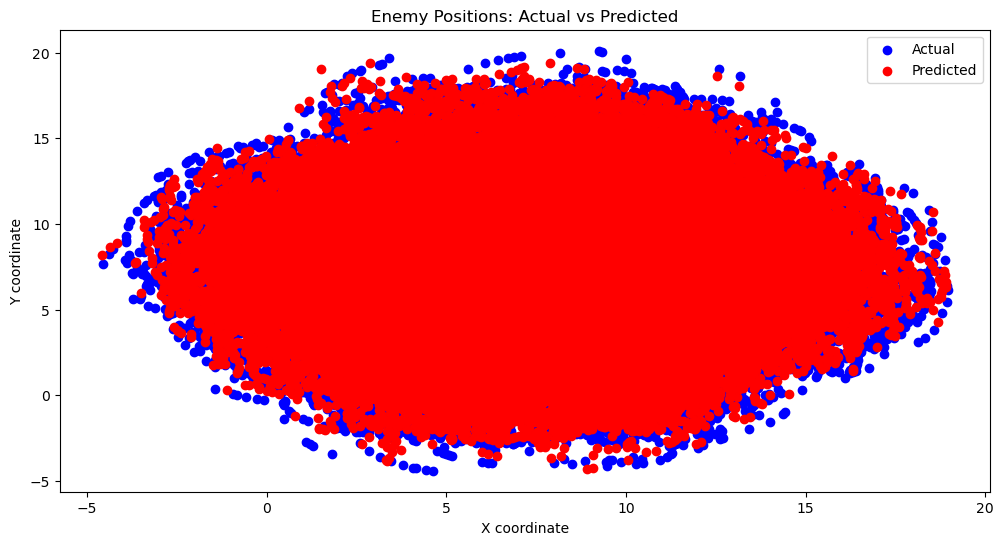

In [23]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], c='b', label='Actual')
plt.scatter(test_predictions[:, 0], test_predictions[:, 1], c='r', label='Predicted')
plt.legend()
plt.title('Enemy Positions: Actual vs Predicted')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

In [24]:
#Plot a sample trajectory
sample_idx = np.random.randint(0, len(ally_data))
sample_ally = ally_data[sample_idx]
sample_enemy = enemy_data[sample_idx]
model.eval()
with torch.no_grad():
    sample_predictions = []
    for i in range(len(sample_ally) - 10):
        input_seq = torch.FloatTensor(sample_ally[i:i+10, :3]).unsqueeze(0).to(device)
        pred = model(input_seq).cpu().numpy()[0]
        sample_predictions.append(pred)

sample_predictions = np.array(sample_predictions)

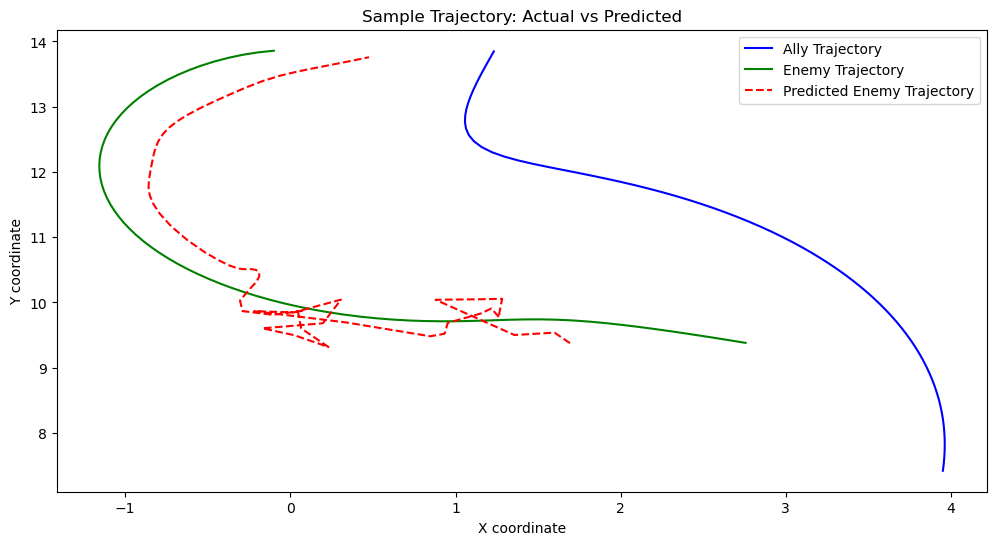

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(sample_ally[:, 0], sample_ally[:, 1], 'b-', label='Ally Trajectory')
plt.plot(sample_enemy[:, 0], sample_enemy[:, 1], 'g-', label='Enemy Trajectory')
plt.plot(sample_predictions[:, 0], sample_predictions[:, 1], 'r--', label='Predicted Enemy Trajectory')
plt.legend()
plt.title('Sample Trajectory: Actual vs Predicted')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()